# UQ in PI model

## Process model
$$
\frac{\partial u}{\partial t} = D \nabla^2 u(x,t) + \rho u (1 - u)
$$


In [115]:
import time
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import scipy.special as sp
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
from numba import jit

We get 2 pretreatment MRIs T1GD which highlyights 80% density of tumour and T2/FLAIR which highlights 16% density.

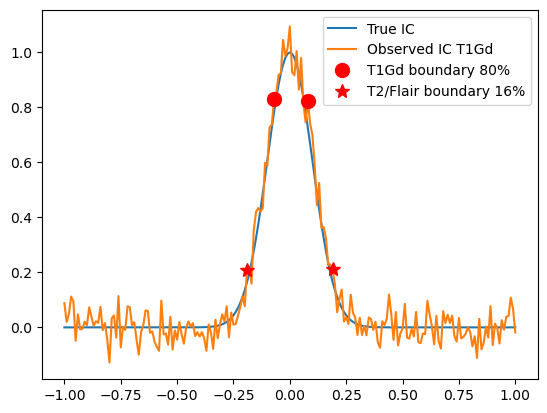

In [104]:
# Generate synthetic data
# Set seed
np.random.seed(0)

dx = 0.01
x = np.arange(-1,1+dx,dx)
mu = 0
sigma_IC = 0.1
IC = 1 / np.sqrt(sigma_IC* 2 * np.pi) * np.exp(-0.5 * ( (x-mu) / sigma_IC)**2)
# normalise IC
IC = IC / np.max(IC) * 1



# Assume adddative guasina noise model, this may eg represent noise in segmetation
# Add noise to IC
sigma = 0.05
r_IC = norm.rvs(mu, sigma, size=len(IC))
#In theory the noise added to the second image which is T2/Flair is independent of the first one
r_IC_T2 = norm.rvs(mu, sigma, size=len(IC))
IC_noise = IC + r_IC
#IC_noise_T2 = IC + r_IC_T2

# find index where tumour is around 0.8 (representing what is seen on T1 boundary)
index_tumour_08 = np.where(IC_noise >= 0.8)[0]
# take only the first and last to indicate the boundary
index_tumour_08 = [index_tumour_08[0], index_tumour_08[-1]]

# find index where tumour is around 16%
index_tumour_016 = np.where(IC_noise >= 0.16)[0]
# take only the first and last to indicate the boundary
index_tumour_016 = [index_tumour_016[0], index_tumour_016[-1]]

plt.plot(x,IC,'-')
plt.plot(x,IC_noise,'-')
#plt.plot(x,IC_noise_T2,'-', color='orange')
plt.plot(x[index_tumour_08], IC_noise[index_tumour_08], 'ro', markersize = 10)
plt.plot(x[index_tumour_016], IC_noise[index_tumour_016], '*', color = 'red', markersize = 10)


plt.legend(['True IC', 'Observed IC T1Gd', 'T1Gd boundary 80%', 'T2/Flair boundary 16%'])
plt.show()

We then potentially get a follow up image 

In [116]:
@jit
def PI_model(x,t,IC,theta,K = 1):

    D = theta[0]
    rho = theta[1]

    u_old = np.zeros(len(x))
    u_new = np.zeros(len(x))
    u_old = IC
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    for i in range(len(t)-1):
        for j in range(1,len(x)-1):
            # Finite difference approximation
            laplacian = (u_old[j+1] - 2*u_old[j] + u_old[j-1]) / dx**2
            growth = rho * u_old[ j] * (1 - u_old[ j] / K)
            u_new[j] = u_old[j] + dt * (D * laplacian + growth)

        # Neumman / no flux BC
        u_new[0] = u_new[1] 
        u_new[-1] = u_new[ -2]  
        u_old = u_new

    return u_new


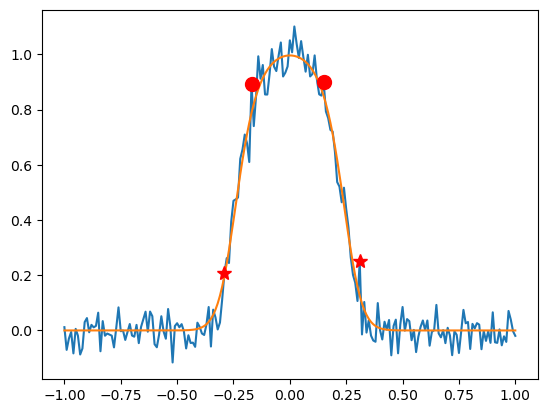

In [117]:

dt = 0.0001
t_final = 5
t = np.arange(0,t_final,dt)
D = 0.0001
rho = 0.5
theta = [D,rho]
u = PI_model(x,t,IC,theta)


# Assume adddative guasina noise model
mu = 0 
r = norm.rvs(mu, sigma, size=len(u))
u_noise = u + r


# find index where tumour is around 0.8 (representing what is seen on T1 boundary)
index_tumour_t2_08 = np.where(u_noise >= 0.8)[0]
# take only the first and last to indicate the boundary
index_tumour_t2_08 = [index_tumour_t2_08[0], index_tumour_t2_08[-1]]

# find index where tumour is around 16%
index_tumour_t2_016 = np.where(u_noise >= 0.16)[0]
# take only the first and last to indicate the boundary
index_tumour_t2_016 = [index_tumour_t2_016[0], index_tumour_t2_016[-1]]

plt.plot(x,u_noise)
plt.plot(x,u)
plt.plot(x[index_tumour_t2_08], u_noise[index_tumour_t2_08], 'ro', markersize = 10)
plt.plot(x[index_tumour_t2_016], u_noise[index_tumour_t2_016], '*', color = 'red', markersize = 10)

plt.show()

To calibrate the model we have these four points

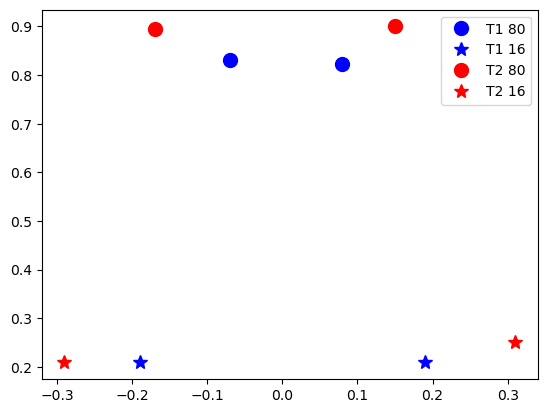

In [118]:
plt.plot(x[index_tumour_08], IC_noise[index_tumour_08], 'bo', markersize = 10)
plt.plot(x[index_tumour_016], IC_noise[index_tumour_016], '*', color = 'blue', markersize = 10)

plt.plot(x[index_tumour_t2_08], u_noise[index_tumour_t2_08], 'ro', markersize = 10)
plt.plot(x[index_tumour_t2_016], u_noise[index_tumour_t2_016], '*', color = 'red', markersize = 10)

plt.legend(['T1 80', 'T1 16', 'T2 80', 'T2 16'])

## logliklihood

In [119]:
def loglhood_single(theta,data,x,t,mu, sigma, neg = True):

    # Evaluate the model solution with parameters a = [U0, h, D, v]
    y = PI_model(x,t,IC,theta)

    # for the x spatial locations where the data is collected find the true value y
    # index where first 80% data comes from
    # Use the indices directly instead of searching
    y_data_match = y[[index_tumour_t2_016[0], index_tumour_t2_08[0], index_tumour_t2_08[1], index_tumour_t2_016[1]]]

    # normal dist
    normal_dist = stats.norm(loc=0, scale=sigma) 
    # calculate the log likelihood
    log_likelihood = normal_dist.logpdf(data - y_data_match) 
    log_likelihood = np.sum(log_likelihood)

    if neg == True:
        return -log_likelihood
    else:
        return log_likelihood


In [120]:

# MLE estimate

# initial guess to start optimization
initial_params = np.array([0.0007,0.3])
# Constrain the params for stability
bounds = [(0, dx**2 / (2*dt) ), (0, 10)]

# Minimize the negative of the log likelihood to find the MLE
neg = True
# The data is just the measurements at 80% and 16%
data = np.array([u_noise[index_tumour_t2_016][0], u_noise[index_tumour_t2_08][0], u_noise[index_tumour_t2_08][1], u_noise[index_tumour_t2_016][1]])
result = minimize(loglhood_single, initial_params, args=(data,x,t,mu,sigma,neg), method = 'Nelder-Mead',bounds = bounds ,tol=1e-10)
# For some reason powell method does not work.

fopt_single = result.fun
D_MLE_single = result.x[0]
rho_MLE_single = result.x[1]

print(f'True D {D}')
print(f'MLE D {D_MLE_single}')
print(f'True rho {rho}')
print(f'MLE rho {rho_MLE_single}')


True D 0.0001
MLE D 0.0
True rho 0.5
MLE rho 0.6367526726890418


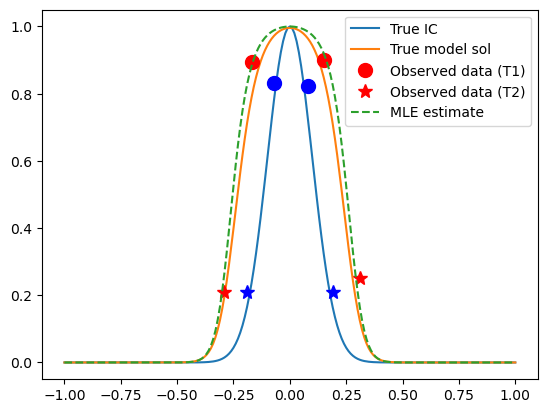

In [125]:

# evaluate model at MLE estimate
MLE_u = PI_model(x,t,IC,result.x)


plt.plot(x,IC, label = "True IC")
plt.plot(x,u,'-', label = "True model sol")
plt.plot(x[index_tumour_08], IC_noise[index_tumour_08], 'bo', markersize = 10, label = None)
plt.plot(x[index_tumour_016], IC_noise[index_tumour_016], '*', color = 'blue', markersize = 10, label = None)

plt.plot(x[index_tumour_t2_08], u_noise[index_tumour_t2_08], 'ro', markersize = 10, label = "Observed data (T1)")
plt.plot(x[index_tumour_t2_016], u_noise[index_tumour_t2_016], '*', color = 'red', markersize = 10, label = "Observed data (T2)")

plt.plot(x,MLE_u,'--', label = "MLE estimate")

plt.legend()



In [126]:
# Function to return the normalised log likelihood (difference between the log likelihood and the optimal value)
def normalised_llhood_single(theta, data,x,t,mu, sigma,fopt_single):
    # Not since fopt comes from the maximization of the negative log likelihood 
    # we add it not subtract it
    return loglhood_single(theta,data,x,t,mu, sigma, neg = False) + fopt_single

In [128]:
# Evaluate the log-likelihood on a Q by Q discretisation of the parmeter space
Q1 = 101 # Q by Q discretisation
Q2 = 101

D_vals_lower = 0.00
D_vals_upper = 0.02
rho_vals_lower = 0.4
rho_vals_upper = 0.6
D_vals = np.linspace(D_vals_lower, D_vals_upper, Q1)  # Range of Ta values
rho_vals = np.linspace(rho_vals_lower, rho_vals_upper, Q2)  # Range of k values
df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

# This should have rows corresponding to k_vals and columns to Ta_vals!!
norm_ll = np.zeros([len(D_vals), len(rho_vals)])

for i in range(len(rho_vals)):
    for j in range(len(D_vals)):
        norm_ll[j,i] = normalised_llhood_single([D_vals[j], rho_vals[i]],data,x,t,mu,sigma,fopt_single)



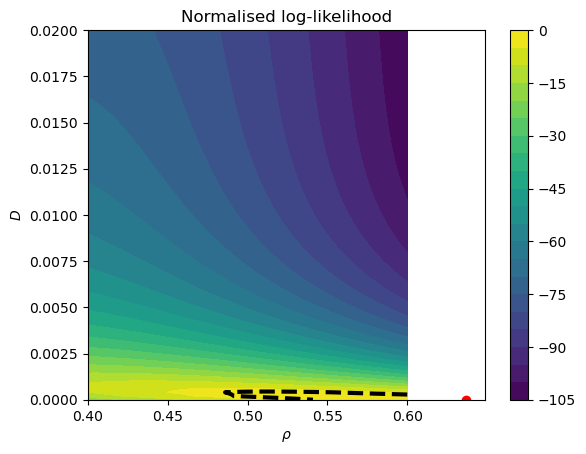

In [129]:
contour_filled = plt.contourf(rho_vals, D_vals, norm_ll, levels=20)
plt.plot(rho_MLE_single, D_MLE_single, 'ro')
plt.contour(rho_vals, D_vals, norm_ll, levels=[llstar], linewidths=3, colors='k')

plt.colorbar(contour_filled)

plt.xlabel(r"$\rho$")
plt.ylabel("$D$")
plt.title("Normalised log-likelihood")
plt.show()
